In [99]:
from astropy import units as u
from astropy.visualization import quantity_support
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve

quantity_support()

%matplotlib widget

In [100]:
# all length units mm

f = 85.
d = f / 1.4

theta_exclude = 10. * u.deg # notional
fov_diag = 11.31 * u.deg # actual, given newer proposed TIM sensor
theta_fov = fov_diag / 2.
assert(theta_exclude > theta_fov) # baffle does not vignette lens

# baffle min height
rb = 25.4 / 4 # free parameter

frac = np.tan(theta_exclude) / np.tan(theta_fov)
# baffle tube diam
D = -d * (1 + frac) / (1 - frac)
# baffle tube length
L = (D / 2 + d / 2) / np.tan(theta_exclude)
D, L, rb

(<Quantity 216.24858706>, <Quantity 785.36725254>, 6.35)

In [101]:
# setup for solving for lots of intersections
p0 = [1,]

def slope(x0, x1, y0, y1):
    m = (y1 - y0) / (x1 - x0)
    return m
def intercept(x, y, m):
    b = y - m * x
    return b
def y(x0, x1, y0, y1):
    m = slope(x0, x1, y0, y1)
    b = intercept(x0, y0, m)
    return lambda x: m * x + b
def func(pts0, pts1):
    x0, x1, y0, y1 = pts0
    xp0, xp1, yp0, yp1 = pts1
    return lambda x: y(x0, x1, y0, y1)(x) - y(xp0, xp1, yp0, yp1)(x)

Baffle Locations: [122.58469746146743, 361.32561935216967, 572.3014229218899, 711.0045421873738]
Baffle Spacings: [238.74092189 210.97580357 138.70311927]
Baffle Radii: [ 42.49549292  66.13564494  87.02649193 100.76088987]
Total Tube Diam.: 228.9485870613765
Total Tube Length: 785.3672525408529


/home/evanmayer/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


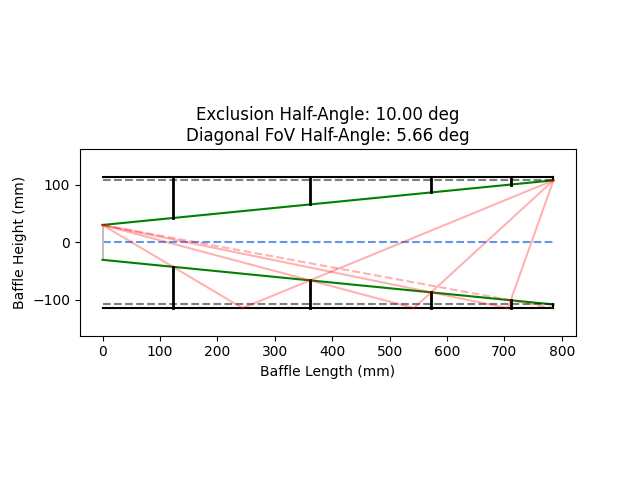

In [102]:
lcolor = 'silver'
bcolor = 'k'
fig, ax = plt.subplots()
ax.set_ylim(-D/2 * 1.5, D/2 * 1.5)
# optical axis
ax.plot([0, L], [0, 0], linestyle='--', color='cornflowerblue')
# objective
ax.plot([0, 0], [-d/2, d/2], color=lcolor)
# marginal ray due to FOV
marginal_ray = [0, L, -d/2, -D/2]
mray_func = y(*marginal_ray)
ax.plot(marginal_ray[:2], marginal_ray[2:], color='g')
ax.plot(marginal_ray[:2], -np.array(marginal_ray[2:]), color='g')
# height of smallest baffle, limits off-axis light
ax.plot([0, L], [-D/2, -D/2], linestyle='--', color=bcolor, alpha=0.5)
ax.plot([0, L], -np.array([-D/2, -D/2]), linestyle='--', color=bcolor, alpha=0.5)
# outer edge of tube
baffle_wall = [0, L, -D/2-rb, -D/2-rb]
ax.plot(baffle_wall[:2], baffle_wall[2:], color=bcolor)
ax.plot(baffle_wall[:2], -np.array(baffle_wall[2:]), color=bcolor)
# first baffle
ax.plot([L, L], [-D/2-rb, -D/2], color=bcolor)
ax.plot([L, L], -np.array([-D/2-rb, -D/2]), color=bcolor)
# critical ray from inside of baffle tube to objective
critical_ray = [0, L, d/2, -D/2-rb]
ax.plot(critical_ray[:2], critical_ray[2:], linestyle='--', color='r', alpha=0.3)

x_wall = L
x_baffle = L
nfev = 100
x_baffles = []
y_baffles = []
while nfev > 0:
    nfev -= 1
    # find the intersection of a critical ray with the lower baffle tube
    x_baffle = fsolve(func(marginal_ray, critical_ray), p0)[0]
    y_baffle = mray_func(x_baffle)
    x_baffles.append(x_baffle)
    y_baffles.append(y_baffle)
    ax.plot([x_baffle, x_baffle], [-D/2-rb, y_baffle], linewidth=2, color=bcolor)
    ax.plot([x_baffle, x_baffle], -np.array([-D/2-rb, y_baffle]), linewidth=2, color=bcolor)
    # find point where of an off-axis ray may illuminate the baffle wall
    off_axis_ray = [L, x_baffle, D/2, y_baffle]
    x_wall = fsolve(func(off_axis_ray, baffle_wall), p0)[0]
    if x_wall < 0:
        break
    critical_ray = [0, x_wall, d/2, -D/2-rb]
    # incident illuminating off-axis ray
    ax.plot([L, x_wall], [D/2, -D/2-rb], color='r', alpha=0.3)
    # critical ray to illuminated point
    ax.plot([0, x_wall], [d/2, -D/2-rb], color='r', alpha=0.3)
ax.set_aspect('equal')
ax.set_xlabel('Baffle Length (mm)')
ax.set_ylabel('Baffle Height (mm)')
ax.set_title(f'Exclusion Half-Angle: {theta_exclude:.2f}\nDiagonal FoV Half-Angle: {theta_fov:.2f}');

print('Baffle Locations:', x_baffles[::-1])
print('Baffle Spacings:', np.diff(x_baffles[::-1]))
print('Baffle Radii:', -np.array(y_baffles)[::-1])
print('Total Tube Diam.:', D + 2 * rb)
print('Total Tube Length:', L)